# Report of D. Karoubi's Bachelor project
### _Evaluating the performance of 3d-printed masks for low-cost lensless imaging_

The following need to be run only once to make sure the local environment is up to date.

In [ ]:
!pip install datasets lensless==1.0.6 waveprop
!pip install git+https://github.com/ebezzam/slm-controller.git

The next cell contains the code to download all the dataset gathered for this project

In [28]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import cv2
from lensless.utils.image import resize
import numpy as np

repo_dict = {
    "FZA_fine": "Lensless/Mirflickr_FZA_fine_1k",
    "FZA_coarse": "Lensless/mirflickr-fza-25k",     # 25k images!
    "CA_fine": "Lensless/mirflickr_CA_fine_1k",    
    "CA_coarse": "Lensless/mirflickr-CA-10k",        # 10k images! 
    "voronoi": "Lensless/mirflickr_voronoi_1k",    
}

huggingface_repo = repo_dict["CA_fine"]
display_res = [900, 1200]   # resolution to display the images
rotate = False   # images were taken upside down

# load dataset
dataset = load_dataset(huggingface_repo, split="test")
print(f"Number of images: {len(dataset)}")

Generating test split: 100%|██████████| 150/150 [00:00<00:00, 169.88 examples/s]


Number of images: 150


## Introduction

Since its creation, camera models have not seen significant changes in the way they opperate. The core concepts of first concentrating enough light in a black space and second, recording this light in a way or an other, have never been suseptible to change. Lensless imaging proposes a completely new aproach to solve this problem by making use of image processing in the very process of taking a picture. 

With the dawn of advanced image processing and Machine Learning (ML) techniques, a new way of taking picture can be imagined. From the pihole principal, it is known that a small hole can concentrate and diffuse light onto a sensible surface to record a scene. This methode, at the root of photography, presents the problem of needing a lot of incoming light to capture a satisfactory image, leading to either the use of an optical system to focus more light, or a longer exposition time.
An other way, although less intuitive, would be to modulate the incoming light in front of the sensor in a predictable way, and then to recover the final image, making use of post processing to solve the coresponding inverse problem. The most basic modulator of this sort would be a pinhole, but with more then just one hole. All the images of each hole would overlap onto each other, but in a very controlled way. Given the position of each hole, one could then reconstructe the initial scene.

This new way of taking picture present many advantages, to be balanced with some trade off. Firstly, this aproach can lead to very flat cameras, as the modulator can be as small, cheap and light as its sensor as well as very close to it, compared to an optical system that can quickely become orders of magnitude bigger and heavier then the sensor itself. This factor has also refrained sensors manufacturers from making them too big, which would not be such a concern anymore with lensless imaging. Finaly, as the image needs the post processing phase to be recovered, this technique allows for build-in visual privacy, as the stored data is essentialy encrypted.
Those gaines have to be contrasted with the two major downsides of lensless imaging, which are the reconstruction quality in one hand, and resources and time needed for the post-processing phase on the other. Those factor alone makes lensless imaging a very minor competitor to classical lensed imaging and they represent the main topic of research in this field.

As it is a rather novel way of taking picture, lensless imaging is mostly done in controled environment, with expensive methods of mask fabrication such as UV-resine lithographie or chrome etching on glass, which also take a considerable amount of time to be manufactured. With this project, the goal is to make use of cheap and accessible 3D-printers to rapidely create masks that can achieve comaprable results, with the hope of making lensless imaging accessible to a wider range of institution and maybe create more traction for the topic.

#### Previous Work

Lensless imaging is divided into two different aproaches, each with their own way of modulating the light in front of the sensor. The first one is reminicent of the basic exemple given in introduction, with the idea of putting more then one hole in front of the sensor, which fall in the category of amplitude masks. Those masks affect light in a very binary way, by either letting light through or blocking it, making them easier to manufacture. The other category corresponds to the phase masks, which act on light in a continuous way, by having a transparent material bend the path of light in various ways. A prime example of such masks is a simple piece of double-sided tape, which create a "floor of swimming pool" -like caustic on the sensor. Whilst harder to fabricated, those mask usualy yield better results as the amont of per pixel variation increases, which translate into finner details when reconstructing the images.


### 3D-Printed Masks

In the mindset of making cheap and accessible masks, 3D-printable masks can be generated in this python library, giving access to either Coded Apperture masks (CA) or Fresnel Zone Aperture ones (FZA). This two techniques are recognise to be working well with micro levels of detail (see [FlatCam](https://arxiv.org/abs/2403.00537#:~:text=In%20this%20paper%2C%20we%20present,%2C%20and%20a%20post%2Dprocessor) for instance) but can be made in coarser resolution to be able to be printed using conventional 3D-printers. The result of which will be measured and compared to other approaches to see if it can be effectively used for further research on Lensless Imaging.

## Methode

Because the aim of this project is minimizing the cost of lensless imaging, the camera used to take the pictures is a Pi-Camera HD, coupled with a RaspberyPi to control it (see [this post](https://medium.com/@bezzam/a-complete-lensless-imaging-tutorial-hardware-software-and-algorithms-8873fa81a660) for more details). In order to take a picture, and eventualy a whole dataset, with this kind of cameras, the following procedure is used. 

First, the Point spread function has to be measured. It is different for each mask and is a key element for the reconstruction. The part on the reconstruction will further explain the importance of the measure. To collect it. A dim light is placed at ~40cm away from the camera, in this case a white LED. When the recorded image is as bright as possible, that is, at the limit of saturating, the image is color corrected and saved. It can now be used for the reconstruction of every picture taken by the corresponding mask.

<div style="text-align:center">
    <img src="color-shifted-psf.png" alt="color-psf" width="20%">
    <img src="psf.png" alt="color-psf" width="20%"><br>
    <i>Right: the psf as recored from the camera, Left: the color-corrected version of the same psf.</i>
</div>


The camera is equiped with a mount that can hold in place a 3D-printed mask as seen in the image below, and is positioned in front of a screen displaying the image to be recorded.

<div style="text-align:center">
    <img src="setup.jpg" alt="setup" width="70%"><br>
    <i>Setup of the dataset collection.</i>
</div>

<div style="text-align:center">
    <img src="mount.jpg" alt="mount" width="40%"><br>
    <i>The inner mount that holds the mask in place, is then screwed onto the part fixed to the camera.</i>
</div>

Note that on this version of the mount, protections have been added during this project to protect the mask from making contact with the sensor. The use of an "adaptor" also allows for smaller versions of the masks to be printed.

To ensure a good quality of the image, the exposition time is adjusted automaticaly when taking the dataset when oversaturation is detected.
The resulting recording looks somthing like the following:

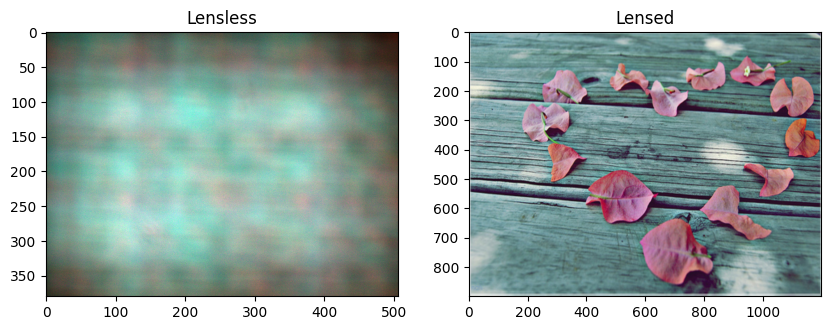

In [29]:
from lensless.utils.image import resize

idx = 1

# take one example
lensless, lensed = np.array(dataset[idx]["lensless"]), np.array(dataset[idx]["lensed"])

if display_res is not None:
    lensed = resize(lensed, shape=(*display_res, 3), interpolation=cv2.INTER_NEAREST)

# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(lensless)
ax[0].set_title("Lensless")
ax[1].imshow(lensed)
ax[1].set_title("Lensed");

Now to reconstruct the image, we make use of an iterative aproach to solve the folowing optimisation problem:

$ \argmin_{x>0} \| \bm{y} - \bm{CPx} \|_2^2 + \tau \| \Psi \bm{x} \|_1$

where:
- $\bm{x}$ is the reconstructed image
- $\bm{y}$ is the recorede image
- $\bm{P}$ is the reconstructed Point Spread Function
- $\bm{C}$ is a croping function
- $\tau \| \Psi \bm{x} \|_1$ is a regulizer (Finite difference) 

In other words, the goal is to start from an initial image $\bm{x}$, compute the convolution with the PSF to get what the camera would see through the mask if it was facing the image $\bm{x}$, compute the distance between what has actually been measured, and minimize this distance, combined with a regularization term. To do so, the gradient with respect of x is computed and x is then modified accordingly, using an algorithm called ADMM.

The following cells recover the corresponding psf, and use it to reconstructe the original image, using this technique. 

In [30]:
from huggingface_hub import hf_hub_download
import torch
from lensless.hardware.sensor import sensor_dict, SensorParam
from lensless.utils.plot import plot_image

sensor = "rpi_hq"
slm = "adafruit"

# simulate PSF for DigiCam
sensor_res = sensor_dict[sensor][SensorParam.RESOLUTION]
downsample_fact = min(sensor_res / lensless.shape[:2])

mask_fp = hf_hub_download(
    repo_id=huggingface_repo, filename="psf_measured.png", repo_type="dataset"
)

PSF shape: torch.Size([1, 380, 507, 3])


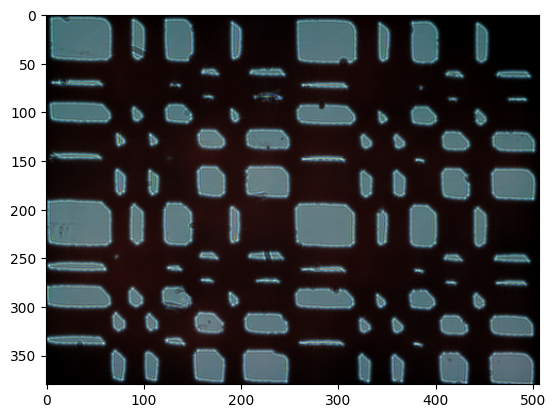

In [31]:
from lensless.utils.io import load_psf

psf = load_psf(mask_fp, downsample=8)
psf = torch.from_numpy(psf).detach()
print("PSF shape:", psf.shape)

# plot PSF
plot_image(psf.numpy());

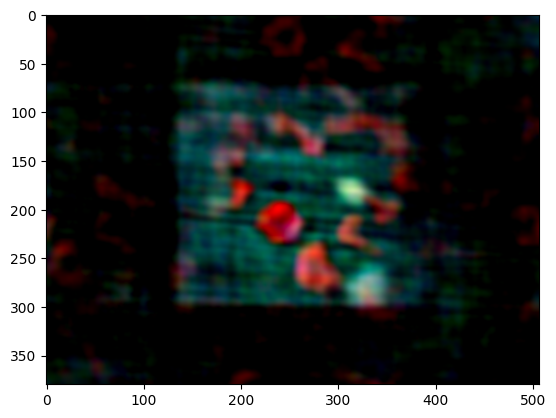

In [32]:
from lensless import ADMM

# prepare data
# -- normalize
lensless = lensless / lensless.max()
# -- to tensor
lensless_torch = torch.from_numpy(lensless).unsqueeze(0).unsqueeze(0).to(psf.device)
if rotate:
    lensless_torch = torch.rot90(lensless_torch, dims=(-3, -2), k=2)

# reconstruct
recon = ADMM(psf)
recon.set_data(lensless_torch)
res = recon.apply(disp_iter=None, plot=False, n_iter=100)

# normalize
res = res - res.min()
res = res / res.max()

# plot reconstruction
plot_image(res.cpu().numpy());

Other techniques can improve this result, making use of learnable parametters in the different phase of the unrolled algorithm (see /scripts/recon/train_learning_based.py for more info), but this imply the use of metrics that are gather in the loop of the learning phase. For them to be meaningful, the reconstructed images cannot be used as is, as only a small part of the image corresponds to the reference image. This yields the need for allignment parameters that have to be fine tune before any training on the collected dataset.  

(-0.5, 279.5, 209.5, -0.5)

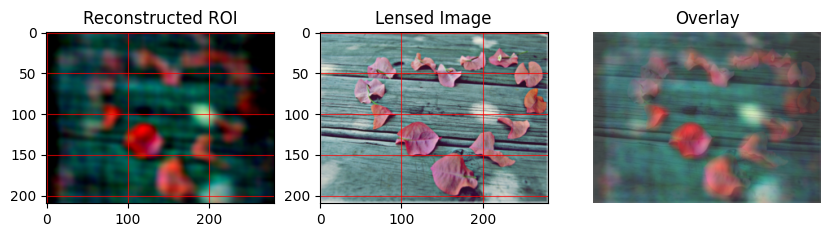

In [33]:
from scipy.ndimage import rotate

# frenel
# top_right = (115, 157)
# height = 180

# coded 
top_right = (80, 120)
height = 210

res_np = res.cpu().numpy().squeeze()

# derive width from height and original aspect ratio
original_aspect_ratio = lensed.shape[1] / lensed.shape[0]
width = int(height * original_aspect_ratio)

# plot extracted reconstruction
recon_roi = res_np[top_right[0]:top_right[0] + height, top_right[1]:top_right[1] + width]


# Rotate
# recon_roi = rotate(recon_roi, 2, reshape=False)

# resize lensed image to match the size of the reconstructed roi
lensed_re = resize(lensed, shape=recon_roi.shape)

# plot roi, lensed, and overlay
_, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 5))
ax[0].imshow(recon_roi)
ax[0].set_title('Reconstructed ROI')
# ax[0].axis('off')
ax[0].grid(alpha=0.7, c='r')
ax[1].imshow(lensed_re)
ax[1].set_title('Lensed Image')
# ax[1].axis('off')
ax[1].grid(alpha=0.7, c='r')
ax[2].imshow(recon_roi, alpha=0.8)
ax[2].imshow(lensed_re, alpha=0.2)
ax[2].set_title('Overlay')
ax[2].axis('off')

Finaly, when the dataset is collected, the psf measured and the reconstruction alligned, all the different benchmark can be run to gather meaningfull metrics as well as reconstructed images from the tested algorithms

## Results

For the evaluation of the 3D-printed masks, three datasets have been collected, each one with a diffent mask. Namely, an Frenel Zone Apperture (FZA) mask, a Coded Aperture (CA) mask, and a Voronoi phase mask. the first two are the mask to be evaluated, while the voronoi phase mask can work as a quality reference for the different benchmark's results. All collected datasets contains $1'000$ images and are availble [online](https://huggingface.co/Lensless).

Lexic:
- ADMM100: Basic Optimization algorithm based on ADMM, for 100 iterations
- Le_ADMM_x: Un-rolled ADMM algotithm using learnable hyper parameters, for x iterations
- P_8: Pre-trained "DruNet" denoiser with 8B parameters, trained only on the last layer (15k param)

_Best results of CA mask benchmark for each algorithm_
| Method          | PSNR   | SSIM  | Recon_ERROR | LPIPS |
|-----------------|--------|-------|-------------|-------|
| ADMM100         | 9.6    | 0.198 | 0.013       | 0.127 |
| LeADMM_5        | 10.9   | 0.273 | 0.0132      | 0.642 |
| LeADMM_10       | 10.9   | 0.272 | 0.0125      | 0.635 |
| LeADMM_5 + P_8  | 12.9   | 0.255 | 0.581       | 0.025 |

<img src="CA_res.png" alt="CA_results" width="70%" style="display:block; margin-left:auto; margin-right:auto;">

_Best results for FZA mask benchmark for each algorithm_
| Method         | PSNR   | SSIM  | Recon_ERROR | LPIPS |
|----------------|--------|-------|-------------|-------|
| ADMM100        | 10.4   | 0.216 | 0.012       | 0.693 |
| LeADMM_5       | 11.1   | 0.255 | 0.028       | 0.607 |
| LeADMM_10      | 11.6   | 0.259 | 0.024       | 0.601 |
| LeADMM_5 + P_8 | 13.686 | 0.338 | 0.040       | 0.560 |

<img src="FZA_res.png" alt="FZA_results" width="70%" style="display:block; margin-left:auto; margin-right:auto;">

The following table contains the resutls of a Tape Camera (the masks used is a piece of double sided tape) and a DigiCam. It can be used as a comparison for the above results. Each entry corresponds to PSNR / SSIM / LPIPS respectivaly.

| Method          | TapeCam              | DigiCam              |
|-----------------|----------------------|----------------------|
| ADMM100         | 10.2 / 0.234 / 0.720 | 10.6 / 0.291 / 0.751 |
| LeADMM5+P_8     | 18.6 / 0.505 / 0.475 | 19.1 / 0.515 / 0.469 |
| P_4+LeADMM5+P_4 | 19.7 / 0.564 / 0.441 | 19.6 / 0.531 / 0.449 |

## Discussion

Unremarkably, the obtained results are somewhat hard to decipher and tend to present many noisy features that downgrade the overall quality of the images. But where as the quality of the reconstructions was expected to be low, the PSNR and the LPIPS values show comparable results as those of the tape camera, meaning that if used correctly, better denoising techniques could be applied on this collected dataset to further imporve the readability of the reconstructed images. Now where the unrolled ADMM and DruNet addition should have considerably improved the reconstruction, there seems to be a potential issue with the alligment parameters used for training, as some artefacts and halucinations are created, both for the FZA and CA mask. Adjusting those parameters better could lead to similar result as those obtained with the tape camera or the DigiCam. 

Overall this project can be considered as a success as the gathered datasets show the potential of low cost, quick to make, and accessible masks for lensless imaging. By training more models on various datasets collected in the same fashion, one can only hope that many more people will want to take part in the future of reaserch in lensless imaging.

For future research, one key aspect that is enable with this new way of making masks is the possibility of training a single reconstruction model onto many dataset, in the hope of finding ways to make denoisers more robust to the variation of the PSF.
An other topic of interest would be to train models not on the measured PSF, but on the simulated one, to see how well the image quality holds compared to the standard approach.